In [1]:
pip install -r requirements.txt

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to c:\users\inies\appdata\local\temp\pip-req-build-gu__zorm
  Cloning https://github.com/amaiya/stellargraph (to revision no_tf_dep_082) to c:\users\inies\appdata\local\temp\pip-req-build-ly5ccfc6



  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=107653 sha256=f05efd4d946451ef307636ba1cee68ae12078c58068e6fe99c0c74745efdfa9e
  Stored in directory: C:\Users\inies\AppData\Local\Temp\pip-ephem-wheel-cache-ttc5dmww\wheels\f8\8c\47\b4cafd3c9519194a489dd614ead1485899d2b34c5adc4198ff
  Created wheel for stellargraph: filename=stellargraph-0.8.2-py3-none-any.whl size=147242 sha256=8338f2bf786fff5ad5e3de8f7e0424eb159cb068937221b43f47cb30a08856ce
  Stored in directory: C:\Users\inies\AppData\Local\Temp\pip-ephem-wheel-cache-ttc5dmww\wheels\4e\67\1a\14af19d488e0925fa17af83a3ce27014e6ae1531f7f11a18cb
Successfully built eli5 stellargraph


In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk
import os

import regex
from nltk.corpus import stopwords 
from nltk.tokenize import WordPunctTokenizer
from string import punctuation
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

from collections import Counter

from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix 
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inies\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import of 20news groups train dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
training_df = pd.DataFrame()
training_df['Text'] = dataset.data
training_df['source'] = dataset.target
label=[]
for i in training_df['source']:
    label.append(dataset.target_names[i])
training_df['Class']=label

In [4]:
training_df.head()

,Text,source,Class
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


In [5]:
training_df.drop(['source'],axis=1,inplace=True)

In [6]:
training_df['Class'].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
sci.space                   593
comp.windows.x              593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: Class, dtype: int64

In [7]:
training_df['Class'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'},inplace=True)
                    
# replace to sport
training_df['Class'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
                    
# replace to religion
training_df['Class'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion'},inplace=True)
                    
# replace to computer
training_df['Class'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'},inplace=True)  
# replace to sales
training_df['Class'].replace({'misc.forsale':'sales'},inplace=True)

# replace to automobile
training_df['Class'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)

# replace to science
training_df['Class'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'},inplace=True)

# replace to medicine
training_df['Class'].replace({'sci.med':'medicine'},inplace=True)

In [8]:
training_df['Class'].nunique()

9

In [9]:
training_df['Class'].value_counts()

computer       2936
science        1779
politics       1575
sport          1197
automobile     1192
religion        976
medicine        594
sales           585
alt.atheism     480
Name: Class, dtype: int64

In [11]:
training_df = training_df[training_df['Class'].isin(['religion', 'automobile', 'medicine','sport'] )]

In [12]:
training_df['words_count'] = training_df['Text'].apply(lambda x:len(str(x).split()))
training_df.head()

,Text,Class,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
17,I recently posted an article asking what kind ...,automobile,1464


In [16]:
no_text = training_df[training_df['words_count']==0]
print(len(no_text))

0


In [14]:
training_df.drop(no_text.index,inplace=True)
print(len(no_text))

124


In [15]:
training_df

,Text,Class,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
17,I recently posted an article asking what kind ...,automobile,1464
...,...,...,...
11296,\n\n\n\n\n Anaheim.,sport,1
11298,After reading some of the reports of possible ...,sport,186
11300,\nI am asking you to believe in things not vis...,religion,447
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,medicine,300


# Import of 20news groups test dataset

In [17]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(subset='test',remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
test_df = pd.DataFrame()
test_df['Text'] = dataset.data
test_df['source'] = dataset.target
label=[]
for i in test_df['source']:
    label.append(dataset.target_names[i])
test_df['Class']=label

In [18]:
test_df.head()

,Text,source,Class
0,I am a little confused on all of the models of...,7,rec.autos
1,I'm not familiar at all with the format of the...,5,comp.windows.x
2,"\nIn a word, yes.\n",0,alt.atheism
3,\nThey were attacking the Iraqis to drive them...,17,talk.politics.mideast
4,\nI've just spent two solid months arguing tha...,19,talk.religion.misc


In [19]:
test_df.drop(['source'],axis=1,inplace=True)

In [20]:
test_df['Class'].value_counts()

rec.sport.hockey            399
soc.religion.christian      398
rec.motorcycles             398
rec.sport.baseball          397
sci.crypt                   396
sci.med                     396
rec.autos                   396
comp.windows.x              395
sci.space                   394
comp.os.ms-windows.misc     394
sci.electronics             393
comp.sys.ibm.pc.hardware    392
misc.forsale                390
comp.graphics               389
comp.sys.mac.hardware       385
talk.politics.mideast       376
talk.politics.guns          364
alt.atheism                 319
talk.politics.misc          310
talk.religion.misc          251
Name: Class, dtype: int64

In [21]:
test_df['Class'].replace({'talk.politics.misc':'politics','talk.politics.guns':'politics',
                     'talk.politics.mideast':'politics'},inplace=True)
                    
# replace to sport
test_df['Class'].replace({'rec.sport.hockey':'sport','rec.sport.baseball':'sport'},inplace=True)
                    
# replace to religion
test_df['Class'].replace({'soc.religion.christian':'religion','talk.religion.misc':'religion'},inplace=True)
                    
# replace to computer
test_df['Class'].replace({'comp.windows.x':'computer','comp.sys.ibm.pc.hardware':'computer',
                    'comp.os.ms-windows.misc':'computer','comp.graphics':'computer',
                    'comp.sys.mac.hardware':'computer'},inplace=True)  
# replace to sales
test_df['Class'].replace({'misc.forsale':'sales'},inplace=True)

# replace to automobile
test_df['Class'].replace({'rec.autos':'automobile','rec.motorcycles':'automobile'},inplace=True)

# replace to science
test_df['Class'].replace({'sci.crypt':'science','sci.electronics':'science','sci.space':'science'},inplace=True)

# replace to medicine
test_df['Class'].replace({'sci.med':'medicine'},inplace=True)

In [22]:
test_df['Class'].nunique()

9

In [23]:
test_df['Class'].value_counts()

computer       1955
science        1183
politics       1050
sport           796
automobile      794
religion        649
medicine        396
sales           390
alt.atheism     319
Name: Class, dtype: int64

In [24]:
test_df = test_df[test_df['Class'].isin(['religion', 'automobile', 'medicine','sport'] )]

In [25]:
test_df['words_count'] =test_df['Text'].apply(lambda x:len(str(x).split()))
test_df.head()

,Text,Class,words_count
0,I am a little confused on all of the models of...,automobile,92
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17
7,A friend of mine managed to get a copy of a co...,religion,87


In [26]:
no_text = test_df[test_df['words_count']==0]
print(len(no_text))

90


In [27]:
test_df.drop(no_text.index,inplace=True)
print(len(no_text))

90


In [28]:
test_df

,Text,Class,words_count
0,I am a little confused on all of the models of...,automobile,92
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17
7,A friend of mine managed to get a copy of a co...,religion,87
...,...,...,...
7520,"First off, if I'm not mistaken, only hibernati...",medicine,95
7522,": \n: >move a little, the pain will be excruti...",medicine,171
7526,1954 MG-TF with frame-up restoration in early ...,automobile,215
7529,"I sent a version of this post out a while ago,...",sport,125


# Dataset Analysis

In [29]:
training_df.columns = ['text', 'target','words_count']
training_df.head()

,text,target,words_count
0,I was wondering if anyone out there could enli...,automobile,91
6,There were a few people who responded to my re...,medicine,63
10,I have a line on a Ducati 900GTS 1978 model wi...,automobile,108
11,"\nYep, that's pretty much it. I'm not a Jew bu...",religion,472
17,I recently posted an article asking what kind ...,automobile,1464


In [30]:
test_df.columns = ['text', 'target','words_count']
test_df.head()

,text,target,words_count
0,I am a little confused on all of the models of...,automobile,92
4,\nI've just spent two solid months arguing tha...,religion,17
5,"\nElisabeth, let's set the record straight for...",medicine,454
6,"Dishonest money dwindles away, but he who gath...",religion,17
7,A friend of mine managed to get a copy of a co...,religion,87


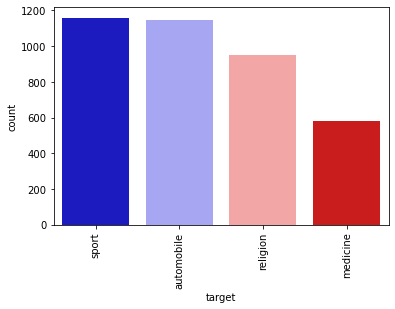

In [31]:
sns.countplot(x=training_df.target, order=[x for x, count in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

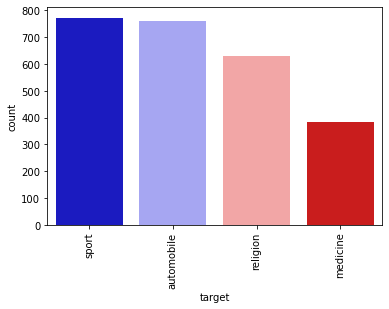

In [32]:
sns.countplot(x=test_df.target, order=[x for x, count in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

In [33]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

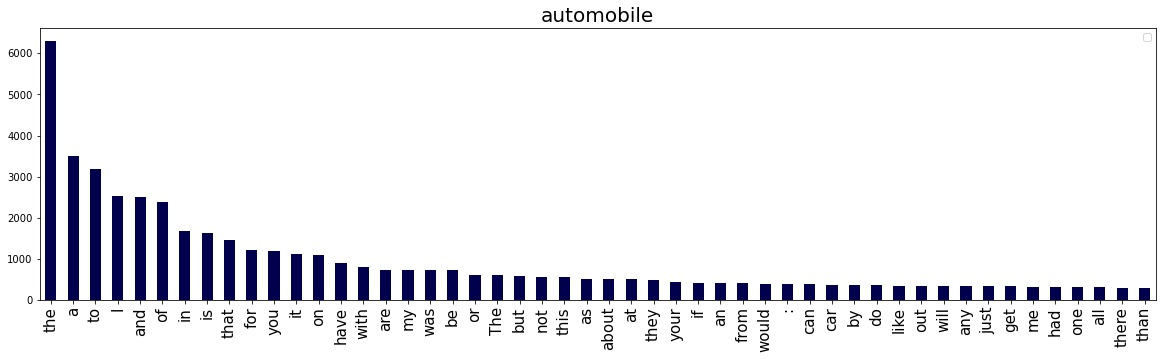

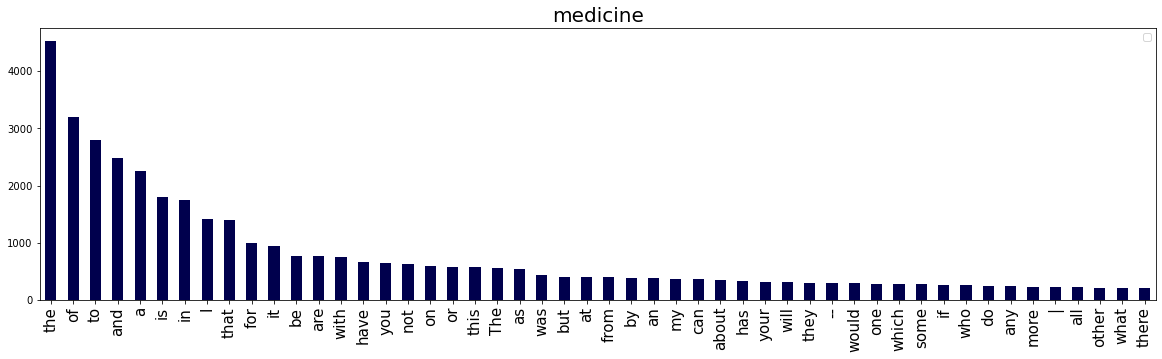

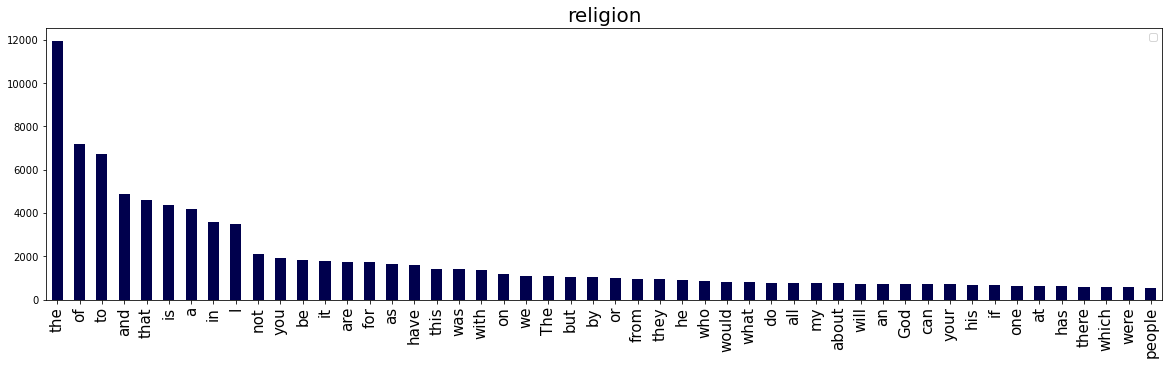

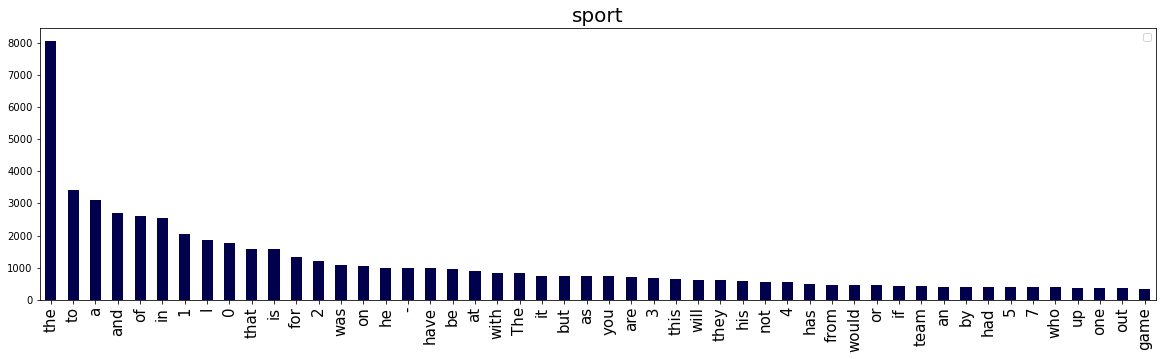

In [34]:
plot_most_common_features(training_df.text, training_df.target)

In [35]:
dataset = pd.concat([training_df,test_df], sort=True)

In [36]:
dataset

,target,text,words_count
0,automobile,I was wondering if anyone out there could enli...,91
6,medicine,There were a few people who responded to my re...,63
10,automobile,I have a line on a Ducati 900GTS 1978 model wi...,108
11,religion,"\nYep, that's pretty much it. I'm not a Jew bu...",472
17,automobile,I recently posted an article asking what kind ...,1464
...,...,...,...
7520,medicine,"First off, if I'm not mistaken, only hibernati...",95
7522,medicine,": \n: >move a little, the pain will be excruti...",171
7526,automobile,1954 MG-TF with frame-up restoration in early ...,215
7529,sport,"I sent a version of this post out a while ago,...",125


In [37]:
from nltk.stem import *
from nltk.corpus import stopwords

import re

def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    letters_only = letters_only.lower()
    letters_only = re.sub('\[.*?\]', '', letters_only)
    letters_only= re.sub('https?://\S+|www\.\S+', '', letters_only)
    letters_only = re.sub('<.*?>+', '', letters_only)
    letters_only = re.sub('[%s]' % re.escape(string.punctuation), '', letters_only)
    letters_only = re.sub('\n', '', letters_only)
    letters_only = re.sub('\w*\d\w*', '', letters_only)
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))  

In [38]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
dataset.head()

,target,text,words_count,clean_text
0,automobile,I was wondering if anyone out there could enli...,91,wonder anyon could enlighten car saw day door ...
6,medicine,There were a few people who responded to my re...,63,peopl respond request info treatment astrocyto...
10,automobile,I have a line on a Ducati 900GTS 1978 model wi...,108,line ducati gt model k clock run well paint br...
11,religion,"\nYep, that's pretty much it. I'm not a Jew bu...",472,yep pretti much jew understand jewish way thin...
17,automobile,I recently posted an article asking what kind ...,1464,recent post articl ask kind rate singl male dr...


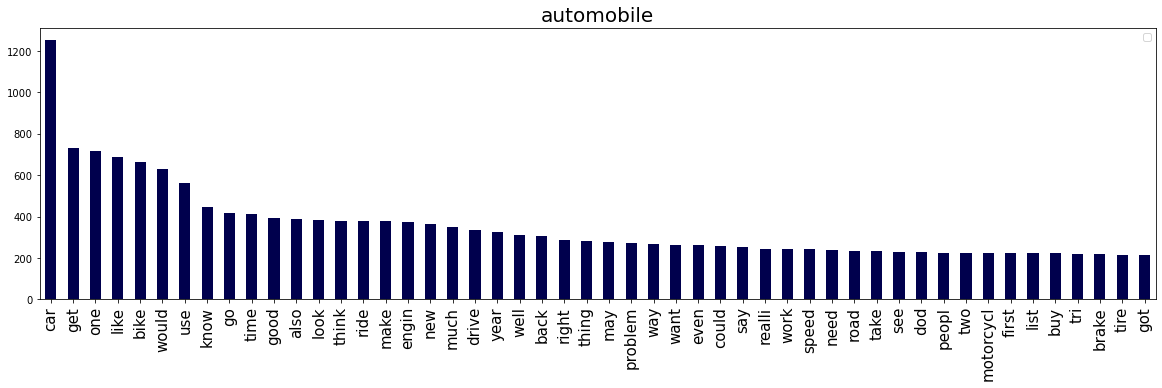

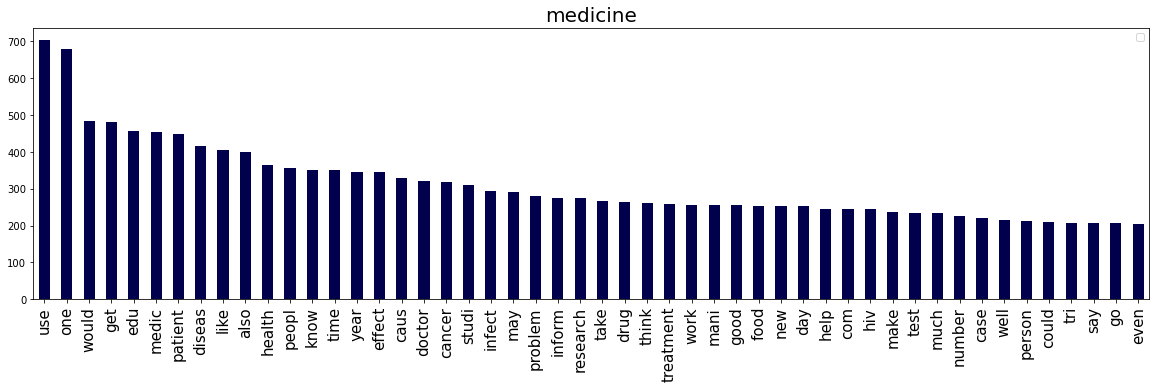

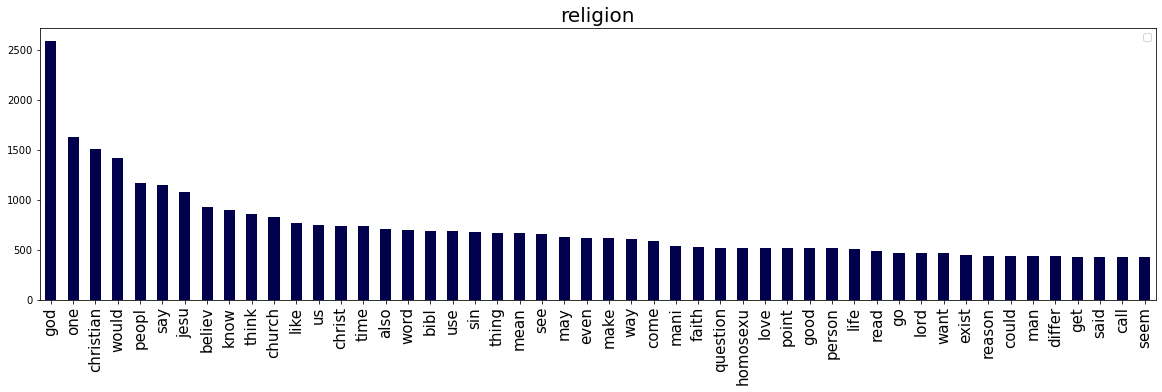

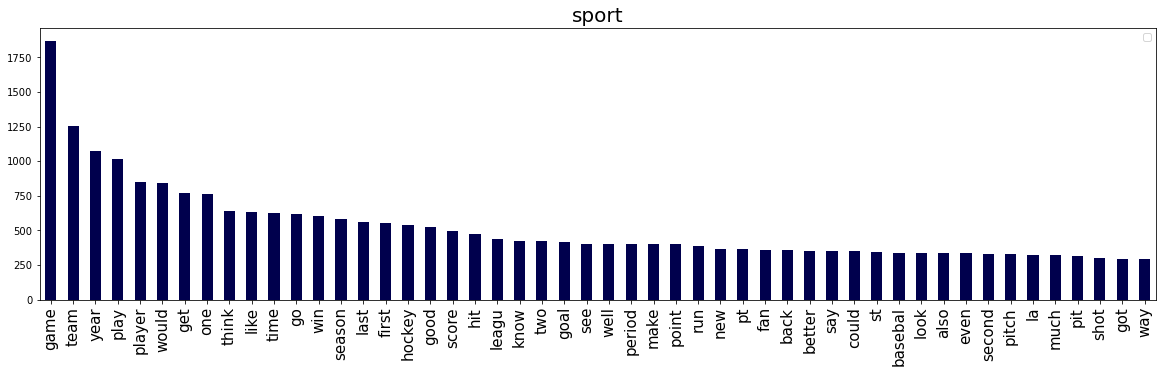

In [39]:
plot_most_common_features(dataset.clean_text, dataset.target)

In [40]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
 
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    return tweet

In [41]:
def process_text(raw_text):      
    raw_text = clean(raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    letters_only = letters_only.lower()
    letters_only = re.sub('\[.*?\]', '', letters_only)
    letters_only= re.sub('https?://\S+|www\.\S+', '', letters_only)
    letters_only = re.sub('<.*?>+', '', letters_only)
    letters_only = re.sub('[%s]' % re.escape(string.punctuation), '', letters_only)
    letters_only = re.sub('\n', '', letters_only)
    letters_only = re.sub('\w*\d\w*', '', letters_only)
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english"))  
    not_stop_words = [w for w in words if not w in stops]

    lem = WordNetLemmatizer()
    stemmed_words = [lem.lemmatize(word) for word in not_stop_words]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in stemmed_words]
    
    return( " ".join( stemmed )) 

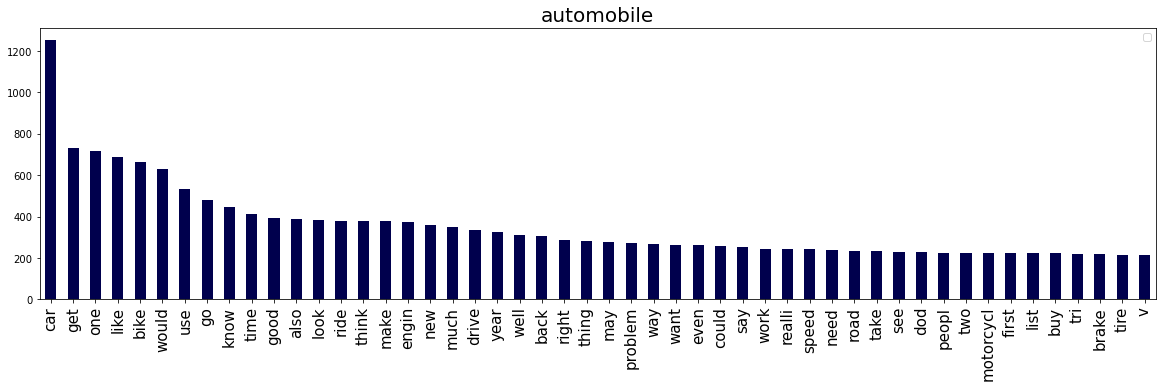

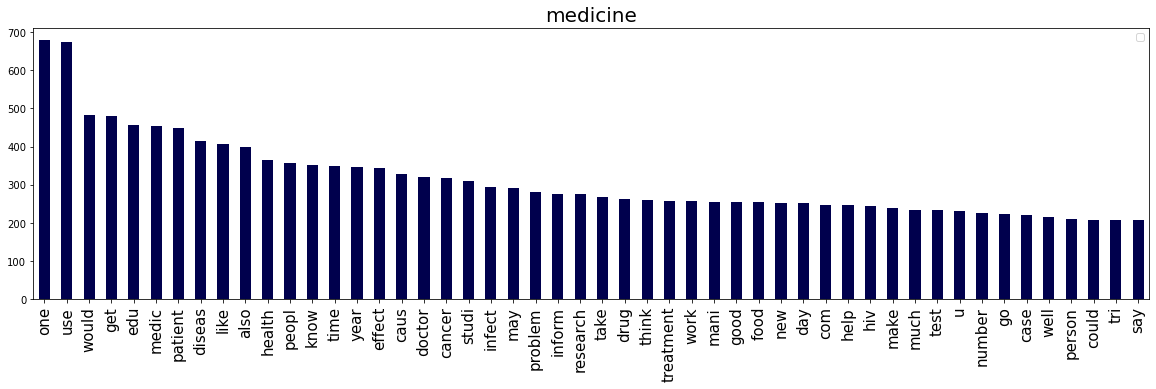

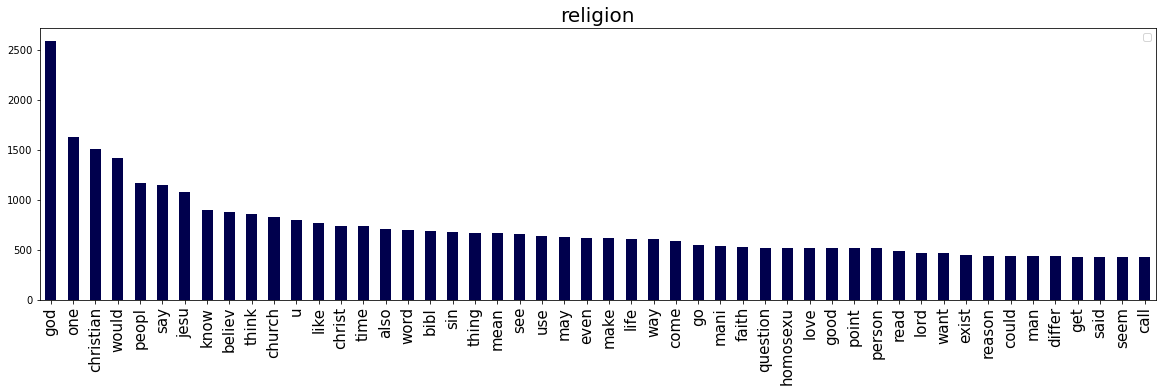

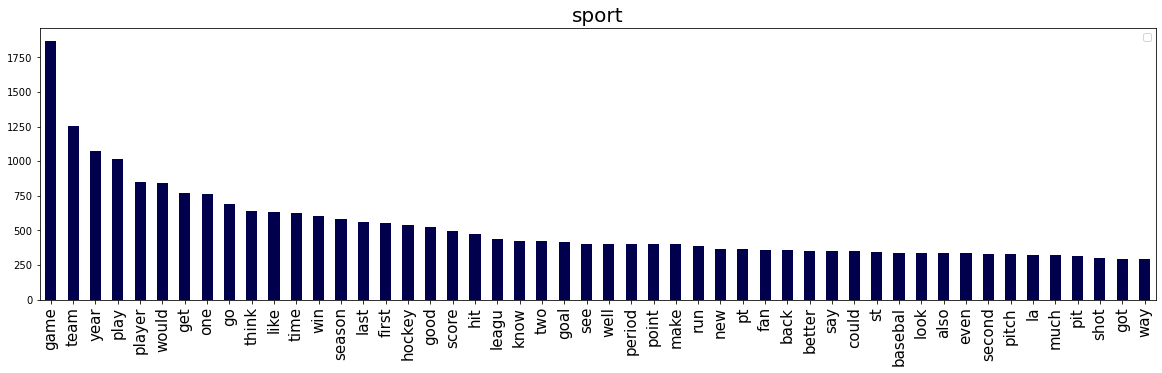

In [86]:
dataset['clean_text'] = dataset['text'].apply(lambda x: process_text(x))
plot_most_common_features(dataset.clean_text, dataset.target)

In [89]:
X_train = dataset[0:len(training_df)][["clean_text"]]
X_test = dataset[len(training_df):len(dataset)][["clean_text"]]

In [90]:
y_train = dataset[0:len(training_df)][["target"]]
y_test = dataset[len(training_df):len(dataset)][["target"]]

# Machine Learning Models

In [91]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.target.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.target.values)

In [92]:
count_vect = CountVectorizer(analyzer = "word")
train_features = count_vect.fit_transform(X_train['clean_text'])
test_features = count_vect.fit_transform(X_test['clean_text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)    

In [93]:
#Missing to include a rebalance of the classes in the train set. SMOTE or equivalent.

In [94]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)
    
    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        best_parameters = grid_search.best_estimator_.get_params()
        print("Best parameters set:",best_parameters)
    return grid_search

# Decision Trees 

In [95]:
# Decision Trees model
from sklearn.tree import DecisionTreeClassifier

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = range(5, 200)
max_features = ['auto', 'sqrt', 'log2']

params_DT = {
    'criterion' : criterion,
    'splitter' : splitter,
    'max_depth' : max_depth,
    'max_features' : max_features
}

DT_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, DecisionTreeClassifier(), params_DT)

Training model
Best score: 0.694
Best parameters set: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 151, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [96]:
#Include a confusion matrix and metrics over the test set- same for all classifiers

# Naive Bayes

In [97]:
nb_text_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, MultinomialNB(), {})

Training model
Best score: 0.880


# SVM

In [ ]:
# SVM model
from sklearn.svm import SVC

svm_grid = [
  {'C': [0.01, 0.1, 1], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
 ]

svm_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, SVC(), svm_grid)

# KNN

In [ ]:
# KNN model
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(5, 6)
weights = ['uniform', 'distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = range(30, 100)
p = range(1, 4)

params_knn = {
    'n_neighbors' : n_neighbors,
    'weights' : weights,
    'algorithm' : algorithm,
    'leaf_size' : leaf_size,
    'p'  : p
}

KNN_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, KNeighborsClassifier(), params_knn)

# MaxEnt Classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
max_ent_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(), max_ent_grid)

# LSTM

In [101]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *

In [102]:
# Language model data
df_all = pd.concat([training_df, test_df])

dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)
).dataloaders(df_all, bs=64, seq_len=40)

dls_lm.show_batch(max_n=5)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


C:\Users\inies\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj of course , xxmaj i 'd still recommend that xxmaj michael read _ true and xxmaj reasonable _ \n by xxmaj douglas xxmaj xxunk . \n\n xxmaj joe xxmaj fisher xxbos xxmaj rex xxmaj xxunk ( xxunk )","xxmaj of course , xxmaj i 'd still recommend that xxmaj michael read _ true and xxmaj reasonable _ \n by xxmaj douglas xxmaj xxunk . \n\n xxmaj joe xxmaj fisher xxbos xxmaj rex xxmaj xxunk ( xxunk ) xxunk"
1,3 0 6 xxup rus xxup buf xxup rw 89 xxmaj alexander xxmaj mogilny \n▁ 3 6 2 4 2 xxwrep 3 0 6 xxup can xxup bos c 49 * joe xxmaj juneau \n▁ 3 5 2 3 2,0 6 xxup rus xxup buf xxup rw 89 xxmaj alexander xxmaj mogilny \n▁ 3 6 2 4 2 xxwrep 3 0 6 xxup can xxup bos c 49 * joe xxmaj juneau \n▁ 3 5 2 3 2 xxwrep
2,", "" elohim "" is translated with a \n capital "" g. "" xxmaj when referring to false gods and goddesses and the judges \n of xxmaj israel , it is translated with a small "" g. "" xxmaj it",""" elohim "" is translated with a \n capital "" g. "" xxmaj when referring to false gods and goddesses and the judges \n of xxmaj israel , it is translated with a small "" g. "" xxmaj it is"
3,"occurring substances known as neurotrophic factors can \n prevent the degeneration of light - sensing cells in the retina of the eye . xxmaj the \n degeneration of these cells , known as photoreceptors , is a major cause of","substances known as neurotrophic factors can \n prevent the degeneration of light - sensing cells in the retina of the eye . xxmaj the \n degeneration of these cells , known as photoreceptors , is a major cause of \n"
4,"from xxmaj his fellowship , not \n because xxmaj he chose to send you into outer darkness , but because you chose to go \n there . \n\n\n\n xxmaj when i rebelled against my earthly father , he spanked me","xxmaj his fellowship , not \n because xxmaj he chose to send you into outer darkness , but because you chose to go \n there . \n\n\n\n xxmaj when i rebelled against my earthly father , he spanked me ."


In [103]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

C:\Users\inies\anaconda3\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


C:\Users\inies\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(lr_min=0.01659586876630783, lr_steep=0.03630780428647995)

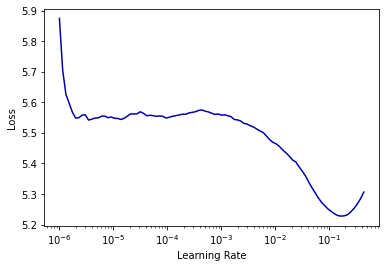

In [104]:
learn.lr_find(start_lr=1e-6, end_lr=1)

In [105]:
learn.fit_one_cycle(1, 1e-2)

C:\Users\inies\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.164141,4.092400,0.271205,59.883446,47:48


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

C:\Users\inies\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.665764,3.916722,0.300469,50.235481,1:12:42


In [ ]:
TEXT = "My country is Spain"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

In [ ]:
learn.save_encoder('ft_enc_extended')

In [ ]:
dls_class = DataBlock(
    blocks=(
        TextBlock.from_df('text', # We take the textual information from the column "text" in the dataset
                          seq_len=40, # Maximum tweet length
                          vocab=dls_lm.vocab # We use the same vocabulary representation than the one used for the LM
                          ), 
            CategoryBlock), # Because we will use these data for classification
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2)) # Randomly splits the dataset (20% for Validation, 80% for training)
.dataloaders(training_df, bs=64)

dls_class.show_batch(max_n=10)

In [ ]:
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.8, metrics=[accuracy,FBeta(beta=1)]).to_fp16()
learn.load_encoder('ft_enc_extended')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.save('lstm_1')

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.save('lstm_2')

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-2/2/(2.6**4),1e-2/2))

In [ ]:
learn.save('lstm_3')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-2/10/(2.6**4),1e-2/10))

In [ ]:
learn.save('lstm_4')

In [ ]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

In [ ]:
learn.save('final_lstm_model')

# Transformers

In [ ]:
# Try a distill transformer and other models.

In [ ]:
import tensorflow as tf
import ktrain
from ktrain import text

In [ ]:
trn, val, preproc = text.texts_from_df(training_df,'text',preprocess_mode='bert',label_columns='target',verbose=True, maxlen=32) # Process the input tweets based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

In [ ]:
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
learner.autofit(lr=1e-4, # Learning Rate 
                epochs=5, # Number of epochs to train the model
                early_stopping=2, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='transformer_cpt_1' # After each epoch we store a checkpoint of the model
                )

In [ ]:
learner.save_model('transformer_1') # Saving the trained model

In [ ]:
learner.unfreeze()
learner.fit_onecycle(1e-4/10, 1, checkpoint_folder='transformer_cpt_2')

In [ ]:
learner.save_model('transformer_2') # Store the final model

In [ ]:
learner.validate(class_names=['Regular Tweet','Disaster Tweet'])

In [ ]:
learner.view_top_losses(n=10, preproc=preproc)

In [ ]:
#!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

predictor.explain("[CLS] the government is concerned about the population explosion and the population is concerned about the government explosion . - joe moore [SEP]")